In [1]:
import pandas as pd
import string
from nltk.corpus import stopwords
import nltk
import torch
from transformers import BertTokenizer, BertModel
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt

C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download NLTK data if not already downloaded
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# Check if GPU is available, and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Load the pre-trained BERT model and tokenizer on the selected device
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)


In [12]:
# Function to remove punctuation
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    text_without_punct = text.translate(translator)
    return text_without_punct

# Function to lowercase text
def lowercase_text(text):
    return text.lower()

# Function to remove stop words
def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def preprocess_text(text):
    text = remove_punctuation(text)
    text = lowercase_text(text)
    text = remove_stop_words(text)
    return text

# Function to get BERT embeddings
def get_bert_embeddings(text):
    # This function should be defined with the appropriate model and tokenizer setup.
    # Make sure to define and load the model and tokenizer before calling this function.
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :]
    return embeddings.cpu().numpy()


In [13]:
# Read the CSV file
data = pd.read_csv('FinalDataF.csv', encoding='latin-1')


In [14]:
# Merge the 'Title' and 'Abstract' columns into a single column called 'Text'
data['Text'] = data['Title'].fillna('') + ' ' + data['Abstract'].fillna('')


In [16]:
# Function to preprocess text
def preprocess_text(text):
    # Add more preprocessing steps as needed
    text = remove_punctuation(text)
    text = lowercase_text(text)
    text = remove_stop_words(text)
    return text

def preprocess_and_get_embeddings(row):
    text = row.get('Text', '')  # Use get() to handle missing values
    embeddings = get_bert_embeddings(text)
    return embeddings

# Assuming 'data' is your DataFrame
data['Text'] = data['Text'].apply(preprocess_text)

# Process and obtain embeddings for each row
embeddings = data.apply(preprocess_and_get_embeddings, axis=1)
embeddings = np.vstack(embeddings.to_numpy())  # Convert to a NumPy array



In [18]:
# Concatenate the embeddings with the original DataFrame
data = pd.concat([data, pd.DataFrame(embeddings)], axis=1)

In [20]:
# Check the shape of text_embeddings
text_embeddings = embeddings  # Assign the embeddings to text_embeddings
print(text_embeddings.shape)  # Should be (number_of_samples, embedding_dimension)

(380, 768)


In [110]:
# Standardize the embeddings
scaler = StandardScaler()
text_embeddings_reshaped = text_embeddings.reshape(text_embeddings.shape[0], -1)
text_embeddings_scaled = scaler.fit_transform(text_embeddings_reshaped)

# Reduce dimensionality with PCA for efficiency
pca = PCA(n_components=0.95)  # Retain 95% of the variance
text_embeddings_pca = pca.fit_transform(text_embeddings_scaled)

# Define the hierarchical_clustering function
def hierarchical_clustering(data, max_d, text_embeddings_pca):
    # Use linkage and fcluster from scipy for hierarchical clustering
    Z = linkage(text_embeddings_pca, method='ward')
    text_cluster_labels = fcluster(Z, max_d, criterion='distance')

    # Add cluster labels to the DataFrame for text embeddings
    data['Text_Cluster'] = text_cluster_labels
    
    return data

# Hyperparameter tuning
max_d_values = [1.0, 2.0, 3.0]  # Try different values of max_d

for max_d in max_d_values:
    clustered_data = hierarchical_clustering(data.copy(), max_d, text_embeddings_pca)

    # Evaluate and visualize the clusters (you can add this part)


In [111]:
# Use linkage and fcluster from scipy for hierarchical clustering
Z = linkage(text_embeddings_pca, method='ward')
max_d = 2  # You can adjust this threshold as needed
text_cluster_labels = fcluster(Z, max_d, criterion='distance')



# Add cluster labels to the DataFrame for text embeddings
data['Text_Cluster'] = text_cluster_labels

# Save the DataFrame with embeddings and clusters to a new CSV file
data.to_csv('cluster_Data.csv', index=False)

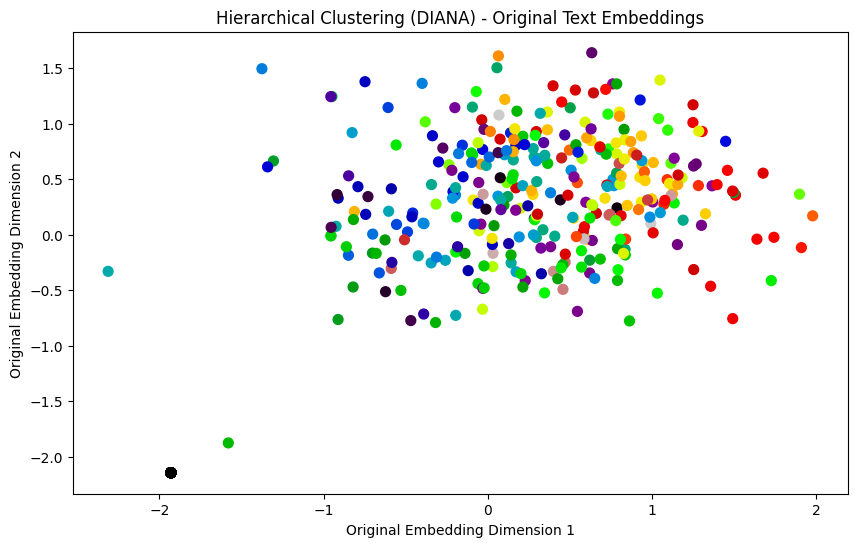

In [113]:
# Create a scatter plot to visualize clusters without PCA
plt.figure(figsize=(10, 6))

# Get the maximum cluster label
max_cluster_label = max(clustered_data['Text_Cluster'])

# Normalize cluster labels between 0 and 1
normalized_labels = clustered_data['Text_Cluster'] / max_cluster_label

# Use normalized_labels for coloring
colors = plt.cm.nipy_spectral(normalized_labels)

plt.scatter(text_embeddings_scaled[:, 0], text_embeddings_scaled[:, 1], c=colors, marker='o', s=50)
plt.title('Hierarchical Clustering (DIANA) - Original Text Embeddings')
plt.xlabel('Original Embedding Dimension 1')
plt.ylabel('Original Embedding Dimension 2')
plt.show()

In [114]:
# Assuming text_cluster_labels contains the cluster labels
max_cluster_label = max(text_cluster_labels)
num_clusters = max_cluster_label

print(f"Number of clusters: {num_clusters}")

Number of clusters: 324


In [115]:
# Check the unique cluster labels in the 'Text_Cluster' column
unique_labels = clustered_data['Text_Cluster'].unique()

# Print the unique cluster labels
print("Unique Cluster Labels:")
print(unique_labels)


Unique Cluster Labels:
[218 131 123  97 248 279 268 265  32  92 244  86  96 111 226 302 108 253
 303  30 146   5 138 163 188 223 104  53 190  15 224 319 269 299 178 198
 235 116 213  28  29  18 168 124 156  98 298   2   9 316 314  57 160 274
  76  84 165 228  61 125 276 304 200 258 236 197  59 232 105 270  41  70
  39  90  42  31 139 215 255  69  33  22 141 296 157 241 300 183 308 187
  73 252 203 204 151 205 245  77 227 161   6 106 320 297 282  54  60 136
 119 321 153  65 284 134 249 237 285   3 195 175 184  93 143 281 212 117
 217 294 173 196  94 101 142  19 234 140  23 301 306 317  88 216  24 278
 275 277 158  14 209  43  91 150  62 162 222 238 283  51  46 256 220 261
 287  48 181 214 128 289 293 221 148 313  78 121 202 260 130 180 135  87
 208 229 189  47 246  27 107 171  58 206 179 315 169  72  44 185 164 310
 118 147 295  99  71 280 311  13 193 272 172 167 305 318  79 267 263 262
 166 132  20 254  85 122  56  67  25 233 109 120 115  95 127  64 271 266
 191 126 199  40  74 242  36

Cluster Label Distribution:
Text_Cluster
1      54
172     2
14      2
127     2
313     2
       ..
60      1
54      1
282     1
297     1
261     1
Name: count, Length: 322, dtype: int64


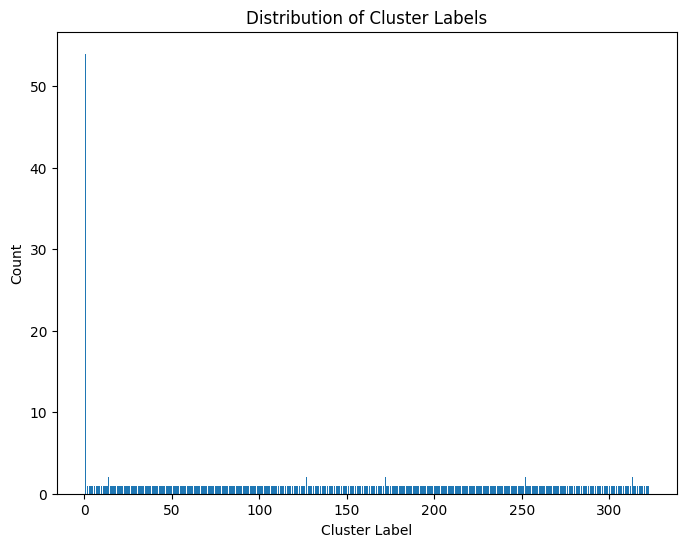

In [116]:
# Count occurrences of each cluster label
cluster_counts = clustered_data['Text_Cluster'].value_counts()

# Print the distribution of cluster labels
print("Cluster Label Distribution:")
print(cluster_counts)

# Visualize the distribution using a bar plot
plt.figure(figsize=(8, 6))
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.title('Distribution of Cluster Labels')
plt.show()


In [117]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score for the clustered data
silhouette_avg = silhouette_score(text_embeddings_scaled, clustered_data['Text_Cluster'])

# Print the silhouette score
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.16589807747878849


In [118]:
print(clustered_data[['Title', 'Abstract', 'Text_Cluster']].head(10))


                                               Title  \
0  A CASE STUDY OF DRIVER'S LICENSE PROCESSES ON ...   
1    A CASE STUDY ON POULTRY EGG PRODUCTION BUSINESS   
2  DESIGN AND DEVELOPMENT OF A FIRE DETECTION AND...   
3  A KNOWLEDGE-BASED SYSTEM N MATCHING TREE, PLAN...   
4  DESIGN AND DEVELOPMENT OF MEMORANDUM PRIORITIZ...   
5  WEB-BASED STUDENT SUBJECT EVALUATION SYSTEM FO...   
6  COMPUTERIZATION OF ENTRANCE EXAM OF NORMISIST ...   
7  A SYSTEM DESIGN FOR UNIFIED TVET PROGRAM REGIS...   
8  MICROFINANCE COLLECTION MONITORING SYSTEM AND ...   
9        ABACADA DIAGNOSTIC AGENT IN PEST MANAGEMENT   

                                            Abstract  Text_Cluster  
0  A Case Study on Driver's License Processes was...           218  
1  A Case Study on Poultry Egg Production Busines...           131  
2  A fire detection and alarm system prototype ba...           123  
3  A Knowledge-Based System on Matching of Tree, ...            97  
4  A memorandum is a means of inter-of

In [119]:
sample_texts = data['Text'].sample(5)  # Get a random sample of 5 texts
for text in sample_texts:
    print(text)

inventory system identification core rural conditions butuan city roads clearly critical enabling condition improving living conditions rural areas however distribution socioeconomic benefits resulting rural road separate issue guarantees inherent mechanisms ensure benefits distributed equitably poor nonpoor communities rural road projects studied ability affect distribution assets skills capacity poor limited largely outside scope nevertheless recognizing assets distributed important understanding benefits accrue planning complementary measures enable lack assets also benefit investment given right complementary activities projects broaden livelihood opportunities poor need support make use opportunities rural roads may bring office city engineer butuan city managing roads condition circumstances since researchers believe decision support system proficient analyzing roads condition situation researchers developed inventory identification core rural road condition assist office city en